In [1]:
import pandas as pd
import numpy as np

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True, usecols=["user_id","anime_id","rating"])

In [5]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy() ## Filtering experienced user from inexperienced user

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler()
rating_df["rating"] = scaler.fit_transform(rating_df[["rating"]])

In [8]:
min(rating_df["rating"])

0.0

In [9]:
max(rating_df["rating"])

1.0

In [10]:
np.mean(rating_df["rating"])

np.float64(0.4073779191986666)

In [11]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [12]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [13]:
# Introducing randomness in the dataframe
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [14]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
user        0
anime       0
dtype: int64

In [15]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y, test_size=1000, random_state=43)

In [17]:
X_train_array = [X_train[: , 0], X_train[:,1]]
X_test_array = [X_test[: , 0], X_test[:,1]]

In [18]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud


In [19]:
n_users = len(user2user_encoded)

In [20]:
n_anime = len(anime2anime_encoded)

In [21]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users,output_dim=embedding_size)(user)
    
    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" ,normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)

    x = Activation("sigmoid")(x) 

    model = Model(inputs=[user,anime], outputs=x)

    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [22]:
model = RecommenderNet()

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,068,544 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,912 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,315,462 (12.65 MB)

 Trainable params: 3,315,460 (12.65 MB)

 Non-trainable params: 2 (8.00 B)

In [24]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [25]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)


In [26]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [27]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.7703 - mae: 0.3776 - mse: 0.1882 - val_loss: 0.7429 - val_mae: 0.3780 - val_mse: 0.1817 - learning_rate: 1.0000e-05
Epoch 2/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - loss: 0.7651 - mae: 0.3760 - mse: 0.1861 - val_loss: 0.7619 - val_mae: 0.3808 - val_mse: 0.1884 - learning_rate: 1.8000e-05
Epoch 3/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 0.7565 - mae: 0.3731 - mse: 0.1826 - val_loss: 0.7561 - val_mae: 0.3796 - val_mse: 0.1862 - learning_rate: 2.6000e-05
Epoch 4/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 0.7438 - mae: 0.3686 - mse: 0.1774 - val_loss: 0.7464 - val_mae: 0.3768 - val_mse: 0.1823 - learning_rate: 3.4000e-05


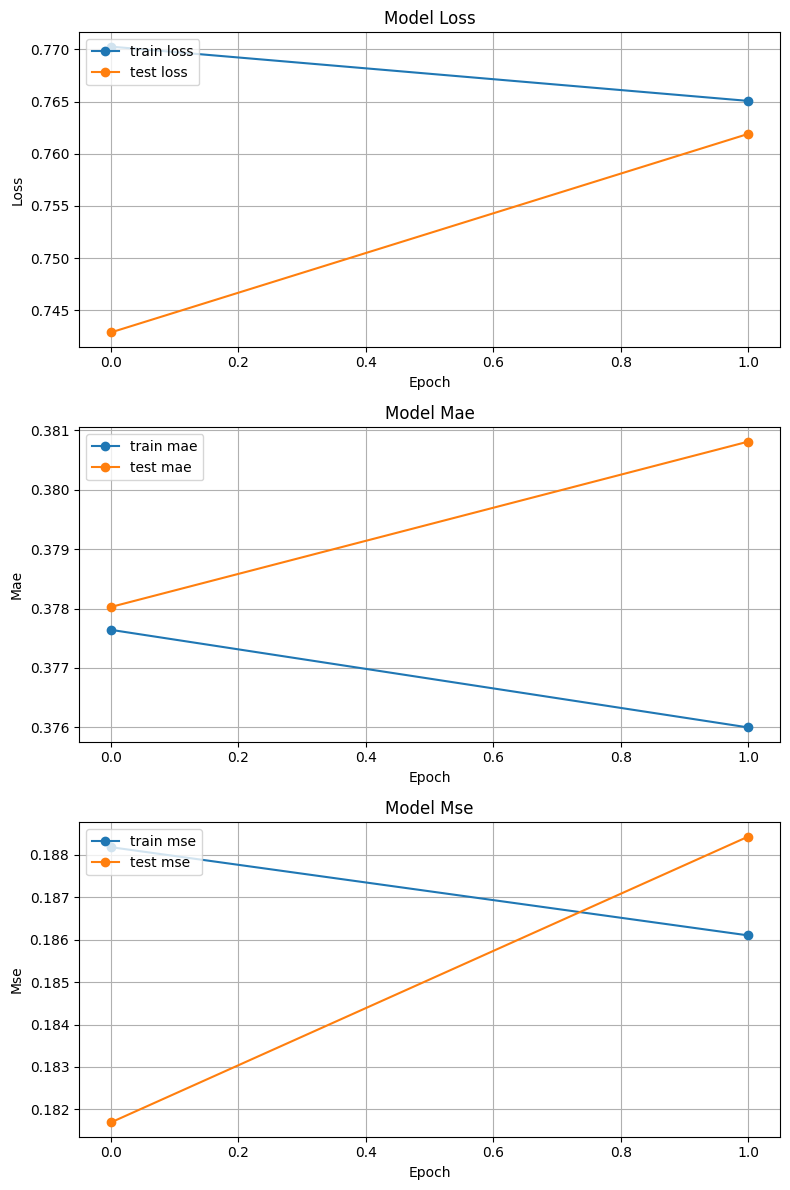

In [28]:
import matplotlib.pyplot as plt
metrics = ["loss","mae","mse"]

#Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) *4 ))

for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:2],marker="o",label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [29]:
def extract_weights(name,model):
    weight_layer= model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [30]:
anime_weights = extract_weights("anime_embedding",model)

In [31]:
user_weights = extract_weights("user_embedding",model)

In [32]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [33]:
df = df.replace("Unknown",np.nan)

In [34]:
df.isnull().sum()

MAL_ID               0
Name                 0
Score             5141
Genres              63
English name     10565
Japanese name       48
Type                37
Episodes           516
Aired              309
Premiered        12817
Producers         7794
Licensors        13616
Studios           7079
Source            3567
Duration           555
Rating             688
Ranked            1762
Popularity           0
Members              0
Favorites            0
Watching             0
Completed            0
On-Hold              0
Dropped              0
Plan to Watch        0
Score-10           437
Score-9           3167
Score-8           1371
Score-7            503
Score-6            511
Score-5            584
Score-4            977
Score-3           1307
Score-2           1597
Score-1            459
dtype: int64

In [35]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]

In [36]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    
    except:
        print("Error")
    return name

In [37]:
df["eng_version"] = df.anime_id.apply( lambda x:getAnimeName(x))

In [38]:
df["eng_version"].isna().sum()

np.int64(0)

In [39]:
df.sort_values(by='Score', inplace=True, ascending=False,kind="quicksort", na_position="last")

In [40]:
df = df[["anime_id","eng_version",'Score','Genres','Episodes','Type','Premiered','Studios','Source']]

In [41]:
df.isnull().sum()

anime_id           0
eng_version        0
Score           5141
Genres            63
Episodes         516
Type              37
Premiered      12817
Studios         7079
Source          3567
dtype: int64

In [42]:
pd.set_option('display.max_rows', None)

In [43]:
df[df['Genres'].isnull()][['anime_id', 'eng_version', 'Genres']]

,anime_id,eng_version,Genres
10145,29765,Metropolis (2009),NaN
10687,30862,Woman Who Stole Fingers,NaN
11471,32695,The Little Match Girl,NaN
11874,33390,Zunda Horizon,NaN
10235,29923,Fukusuke,NaN
10233,29921,Bunbuku Chagama (1958),NaN
12743,34993,The Lazy Fox,NaN
11763,33187,Katsudou Shashin,NaN
11136,31834,Mormorando,NaN
9839,28655,PiKA PiKA,NaN


In [44]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [45]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,MAPPA,Manga


In [46]:
getAnimeFrame("Gintama Season 4",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,Bandai Namco Pictures,Manga


In [47]:

syn_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",low_memory=True)

In [48]:
syn_df.drop(columns=['Score'], inplace=True)

In [49]:
replace = df.copy()

In [50]:
replace.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,Bones,Manga
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,MAPPA,Manga
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,White Fox,Visual novel
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,Wit Studio,Manga
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,Bandai Namco Pictures,Manga


In [51]:
syn_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [52]:
syn_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [53]:
# Merge syn_df with the 'anime_id' and 'eng_version' columns from df
syn_df = syn_df.merge(df[['anime_id', 'eng_version']], left_on='MAL_ID', right_on='anime_id', how='left')

# If you want, you can drop the redundant 'anime_id' column
syn_df.drop(columns=['anime_id'], inplace=True)

In [54]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return syn_df[syn_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return syn_df[syn_df.eng_version == anime].sypnopsis.values[0]

In [55]:
getSynopsis("Gintama Season 4",df)

"Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an alternate-reality Edo, where swords are prohibited and alien overlords have conquered Japan, they try to thrive on doing whatever work they can get their hands on. However, Shinpachi and Kagura still haven't been paid... Does Gin-chan really spend all that cash playing pachinko? Meanwhile, when Gintoki drunkenly staggers home one night, an alien spaceship crashes nearby. A fatally injured crew member emerges from the ship and gives Gintoki a strange, clock-shaped device, warning him that it is incredibly powerful and must be safeguarded. Mistaking it for his alarm clock, Gintoki proceeds to smash the device the next morning and suddenly discovers that the world outside his apartment has come to a standstill. With Kagura and Shinpachi at his side, he sets off to get the device fixed; though, as usual, nothing is ever that simple for the Yorozuya team. Filled with tongue-in-cheek

In [56]:
def getSynopsis1(anime):
    if isinstance(anime, int):
        result = syn_df[syn_df.MAL_ID == anime]
        if not result.empty:
            return result.sypnopsis.values[0]
    elif isinstance(anime, str):
        result = syn_df[syn_df.eng_version == anime]
        if not result.empty:
            return result.sypnopsis.values[0]
    return None

In [57]:
getSynopsis(2,df)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [58]:
getSynopsis1(1)

'In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member\'s dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic an

In [59]:
getSynopsis1(34755)

nan

In [60]:
syn_df[syn_df.isnull().any(axis=1)]

,MAL_ID,Name,Genres,sypnopsis,eng_version
11451,34755,Kuma no Gakkou: Patissier Jackie to Ohisama no...,"Comedy, Kids",NaN,Kuma no Gakkou: Patissier Jackie to Ohisama no...
11469,34794,Yukai na Animal Bus,"Comedy, Kids",NaN,Funny Animal Bus
13686,38475,Yuru Camp△ Movie,"Comedy, Slice of Life",NaN,Yuru Camp△ Movie
15025,40714,Youkai Watch Jam: Youkai Gakuen Y - N to no So...,"Comedy, Demons, Kids, Supernatural, School",NaN,Youkai Watch Jam: Youkai Gakuen Y - N to no So...
15747,42717,Kaeru no Pickles: Kimochi no Iro,"Slice of Life, Kids",NaN,Kaeru no Pickles: Kimochi no Iro
16056,44848,Iii Icecrin,Kids,NaN,Iii Icecrin
16110,45731,Argonavis from BanG Dream! Movie,Music,NaN,Argonavis from BanG Dream! Movie
16120,46095,Vivy: Fluorite Eye's Song,Sci-Fi,NaN,Vivy: Fluorite Eye's Song


In [61]:
syn_df.isnull().sum()

MAL_ID         0
Name           0
Genres         0
sypnopsis      8
eng_version    0
dtype: int64

In [62]:
pd.set_option("max_colwidth",None)

In [63]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,Bones,Manga
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,MAPPA,Manga
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,White Fox,Visual novel
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,Wit Studio,Manga
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,Bandai Namco Pictures,Manga


In [64]:
def find_similiar_animes(name,anime_weights,anime2anime_encoded,
                         anime2anime_decoded,df,n=10,return_dist=False,neg=False):
    
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]
        

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            

            anime_frame = getAnimeFrame(decoded_id,df)
            synopsis = getSynopsis1(decoded_id)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                "synopsis" : synopsis
                
            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
    
    except Exception as e:
        print("Error occured",e)
    

In [96]:
find_similiar_animes("Fullmetal Alchemist:Brotherhood",anime_weights,anime2anime_encoded,anime2anime_decoded,
                     df)

,name,similarity,genre,synopsis
1,Magic Han War,0.354618,"Adventure, Kids, Magic, Martial Arts","Born from within the magical character stones, Oki grew up around the ancient mountain monkeys until one day, he left to collect all of the magic character stones scattered throughout the world. During his journey, he meets Bori, a master in the arts of the magical character stones and together, they set off on a journey to train in the ancient arts of character magic. One day, as Bori was training Oki in the arts of character magic, they run into Master Sal, who tells them about the mysterious sorcerer, Jin. Jin is collecting the 108 magic runes to resurrect the evil dark lord Chaos and it’s up to Oki and his new found friends, as well as his knowledge of the character stones to stop Jin from resurrecting Lord Chaos in time. But will he be able? (Source: Official Site) The franchise is meant to be an educational series helping children learn hanja, which are Chinese characters borrowed from Chinese and incorporated into the Korean language with Korean pronunciation. The TV anime was entirely produced in stereoscopic 3D CG. Children could watch the how with red-blue 3D glasses. Later a non-stereoscopic 3D version was rebroadcasted that did not require glasses."
2,Shin Kaitei Gunkan,0.306101,"Action, Adventure, Fantasy, Historical, Military, Sci-Fi","oments after an atomic bomb falls over Hiroshima, a secret Japanese submarine sails into battle against its American counterpart, and both are lost to history. Some fifty years later, a special UN task force sent to investigate unusual phenomena in Antarctica is threatened by a mysterious black cylinder. (Source: ANN)"
3,Kitty-Cat Fantasia,0.300774,Comedy,"""Shiro"" is a black cat who loves her family very much. She loves them so much she wants to help them out in times of need and trouble…but it’s difficult to do this if she’s just a cat. So one night, she wishes on the moon to make her able to help, and the next day, she has turned into a human girl. (Source: AniDB)"
4,Doraemon the Movie:Nobita and the Haunts of Evil,0.292238,Adventure,"Nobita finds an stray dog and brings him home, little does he knows that the dog is actually a prince in his homeland, a world appart deep in the african ""Smokers Forest"" were the dogs evolved and have their own empire, so he and his friends take on a journey to take back the young prince to his homeland but when they get there things have changed... (Source: ANN)"
5,Princess Jellyfish,0.288300,"Slice of Life, Comedy, Josei","Ever since her late mother took her to an aquarium when she was young, Tsukimi Kurashita has been obsessed with jellyfish, comparing their flowing tentacles to a princess's white dress. Now living with five other unemployed otaku women, 19-year-old Tsukimi spends her days as a social outcast dreaming of becoming an illustrator. However, her life changes forever when one day, a beautiful woman unexpectedly helps her save a jellyfish in a local pet store. From then on, the stranger—confident, fashionable, and the complete opposite of Tsukimi and her roommates—begins to regularly visit the girls' building. This trendy hipster, though appearing shallow at first, harbors some secrets of her own, starting with the fact that ""she"" isn't really a girl at all, but a wealthy male college student named Kuranosuke Koibuchi!"
6,SWEET TOUCH OF LOVE,0.287775,Dementia,"The film is comprised of a countdown leader that goes backwards and forwards mixed in with an animated Marilyn Monroe seductively eating a banana. It was made for the 1st 100-ft Film Festival, organized by the Underground Center, with a line-up of works made with one 100-ft reel of film. (Source: Collaborative Cataloging Japan)"
7,Kabushikigaisha Aokishouji,0.282956,Comedy,TV commercials for the insurance agency Aokishouji animated by Takashi Taniguchi for the Miyazaki Prefecture. They were posted online the same day as the TV airings.
8,Shounen Santa no Daibouken!,0.282855,"Ad

In [98]:
find_similiar_animes("Attack on Titan",anime_weights,anime2anime_encoded,anime2anime_decoded,
                     df)

,name,similarity,genre,synopsis
1,Kamen Rider Fourze x Crayon Shin-chan,0.323619,"Action, Comedy, Seinen","Four short crossover episodes, collectively titled Kamen Rider Fourze × Crayon Shin-chan between Kamen Rider Fourze and Crayon Shin-chan were shown in each show's time slots during April 2012 to promote their respective series' new films: Kamen Rider × Super Sentai: Super Hero Taisen and Crayon Shin-chan: The Storm Called!: Me and the Space Princess. The characters will crossover in two episodes of each respective series. The story follows Shin-chan teaming up with Kamen Rider Fourze in order to go to space and rescue Shin's younger sister who had been taken to Planet Himawari to become its princess. The first and fourth episodes feature both anime and live-action while the second and third were entirely animated. (Source: Wikipedia)"
2,Baby Grandma,0.316038,"Comedy, Drama","mika is a elementary school student who dreams of becoming an idol. Her grandmother is a harsh yet wealthy woman who lives on a remote island that she owns. When her grandmother passed away, Amika's life begins to appear subtle changes. Not long after the passing of her grandmother, Amika's mother gave birth to a baby girl. Ironically, Amika's little sister looks and behaves exactly like her grandmother. (Source: ANN)"
3,Decadence-Remix-,0.312741,"Military, Music",usic video for Heavenstamp's Decadence (Animal Collective remix) song created by Rabbit MACHINE for their 2012 music video competition.
4,I'm from Japan,0.299171,"Slice of Life, Comedy, Shounen","There's a new tough guy transfer student in Tokyo. His name is Tokio and he's raring to see how scrappy the locals are. But when he comes face-to-face with a Japan-obsessed red-haired kid that won't leave him alone until he tells him exactly what prefecture he's from, his life takes a turn for the crazy! This kid isn't just Japan obsessed, he's developed a martial art based on all the different prefectures in the country! (Source: VIZ Media)"
5,Dragon Ball Z:The Return of Cooler,0.292705,"Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Cooler has resurrected himself as a robot and is enslaving the people of New Namek. Goku and the gang must help. (Source: ANN)
6,Sonyeon 007 Eunhateukgongdae,0.291826,"Action, Adventure, Mecha, Sci-Fi, Shounen, Space",1980 Korean Mecha movie from 007 franchise.
7,Snow White with the Red Hair 2,0.289495,"Drama, Romance, Fantasy, Shoujo","Shirayuki and Zen Wistalia have finally confirmed their romantic feelings for each other, and everyone has resumed their daily lives. Shirayuki remains an apprentice court herbalist at the royal palace of Clarines, and Zen continues his duties alongside his aides. However, their daily routines are disrupted when Crown Prince Izana, Zen’s older brother, receives an invitation from Raji Shenazard, the prince of Tanbarun. The herbalist finds herself ordered to go to Tanbarun for seven days, to build a new friendship with the formerly selfish and haughty ruler who once ordered Shirayuki to become his concubine. Along the way, Shirayuki is bound to run into trouble once again, as she is sought by a mysterious boy named Kazuki, someone she has never met."
8,Magic Knight Rayearth,0.288991,"Adventure, Comedy, Drama, Fantasy, Magic, Mecha, Romance, Shoujo","Hikaru Shidou, Umi Ryuuzaki, and Fuu Hououji are strangers brought together by fate when they meet during a seemingly normal field trip to Tokyo Tower. Accompanied by a great flash of light, they hear a mysterious woman's plea to save ""Cephiro,"" and the junior high heroines are suddenly swept away by a giant flying fish. Afterwards, they arrive in an unknown land, where they encounter a man called Master Mage Clef. Clef informs the girls that they were summoned by Princess Emeraude to fulfill their destinies as Magic Knights, restoring peace and balance in Cephiro. The formerly lively and peaceful land has been in disarray ever since High Priest Zagato imprisoned the princess, who act

In [66]:
def find_similiar_user(item_input, user_weights,user2user_encoded,
                       user2user_decoded,n=10,return_dist=False,neg=False):
    try:
        index = int(item_input)
        encoded_index = user2user_encoded.get(index)
        weights = user_weights

        if encoded_index is not None:

            dists = np.dot(weights,weights[encoded_index])
            sorted_dists = np.argsort(dists)

            n=n+1
            
            if neg:
                closest = sorted_dists[:n]
            else:
                closest = sorted_dists[-n:][::-1]
            

            if return_dist:
                return dists,closest
            
            SimiliarityArr = []

            for close in closest:
                similarity = dists[close]

            
                decoded_id = user2user_decoded.get(close)
                SimiliarityArr.append({
                    "similiar_users" : decoded_id,
                    "similarity" : similarity,
                    
                })
                
                sim_users = pd.DataFrame(SimiliarityArr).sort_values(by="similarity",ascending=False) 
                sim_users = sim_users[sim_users.similiar_users != item_input]
            return sim_users
        else:
            print(f"Cannot find similiar users for {item_input}! ")
    except Exception as e:
        print("Error occured",e)
         

In [67]:
find_similiar_user(11880,user_weights,user2user_encoded,user2user_decoded)

,similiar_users,similarity
1,10652,0.371073
2,14914,0.297201
3,12023,0.296664
4,24950,0.294215
5,3784,0.286973
6,6114,0.286564
7,23962,0.280879
8,30141,0.276663
9,12682,0.271375
10,2547,0.271139


In [68]:
find_similiar_user(1,user_weights,user2user_encoded,user2user_decoded)

Cannot find similiar users for 1! 


In [69]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [70]:
from collections import defaultdict

In [71]:
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list =[]
    for genres in frame['Genres']:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    
    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [72]:
cb = getAnimeFrame(1,df)

In [73]:
cb

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,Sunrise,Original


In [74]:
getFavGenre(cb)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

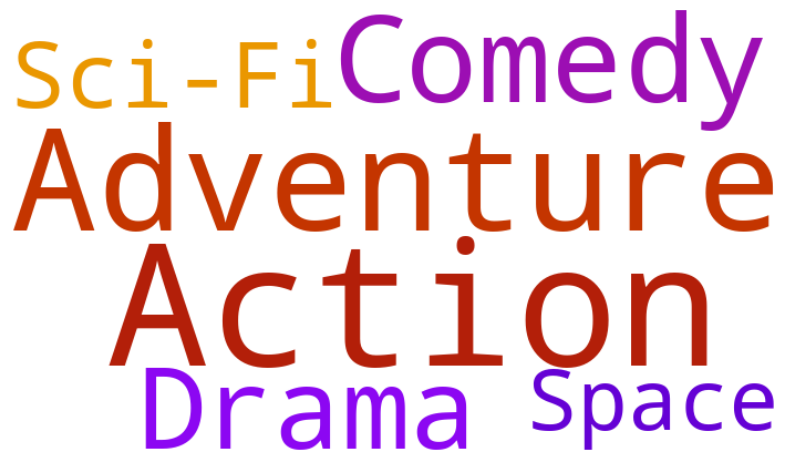

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [75]:
getFavGenre(cb , plot=True)

In [76]:
def get_user_preferences(user_id, rating_df,df, verbose=0, plot=False ):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    if not animes_watched_by_user.rating.empty:
        user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)
    else:
        user_rating_percentile = np.nan


    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating",ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if not anime_df_rows.empty :
      if plot:
          getFavGenre(anime_df_rows, plot=True)
    

    return anime_df_rows


In [77]:
get_user_preferences(0,rating_df,df)

,eng_version,Genres


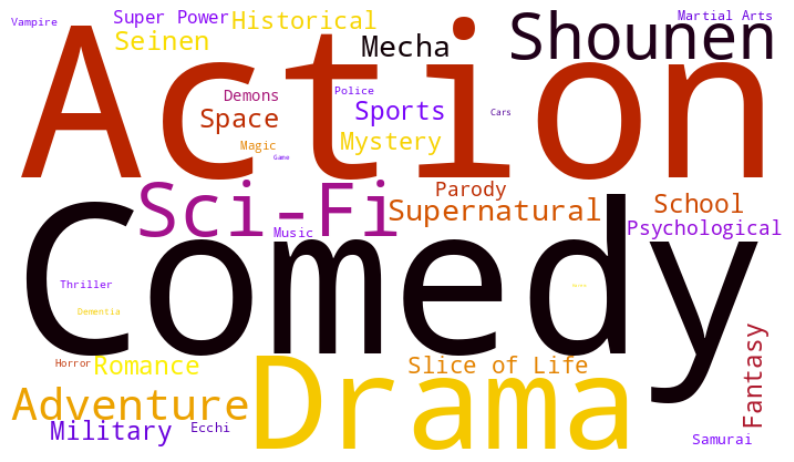

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7249,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
833,Gintama,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7577,Monogatari Series:Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"


In [78]:
get_user_preferences(11880,rating_df,df,plot=True)

In [79]:
def get_user_recommendations(similar_users,user_pref,df,rating_df,syn_df,n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similiar_users.values:
        pref_list = get_user_preferences(user_id,rating_df,df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i,anime_name in enumerate(sorted_list.index):
            n_users_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name,df)
                genre = frame.Genres.values[0]
                synopsis = getSynopsis1(anime_name)

                recommended_animes.append({
                    "n" : n_users_pref,
                    "anime_name" : anime_name,
                    "Genres": genre,
                    "synopsis" : synopsis
                })
    return pd.DataFrame(recommended_animes).head(n)
               

    

In [80]:
sim_users = find_similiar_user(24730,user_weights,user2user_encoded,user2user_decoded)

In [81]:
use_pre = get_user_preferences(24730,rating_df,df)

In [82]:
get_user_recommendations(similar_users=sim_users,user_pref=use_pre,df=df,rating_df=rating_df,syn_df=syn_df)

,n,anime_name,Genres,synopsis
0,7,Rascal Does Not Dream of Bunny Girl Senpai,"Comedy, Supernatural, Drama, Romance, School","The rare and inexplicable Puberty Syndrome is thought of as a myth. It is a rare disease which only affects teenagers, and its symptoms are so supernatural that hardly anyone recognizes it as a legitimate occurrence. However, high school student Sakuta Azusagawa knows from personal experience that it is very much real, and happens to be quite prevalent in his school. Mai Sakurajima is a third-year high school student who gained fame in her youth as a child actress, but recently halted her promising career for reasons unknown to the public. With an air of unapproachability, she is well known throughout the school, but none dare interact with her—that is until Sakuta sees her wandering the library in a bunny girl costume. Despite the getup, no one seems to notice her, and after confronting her, he realizes that she is another victim of Puberty Syndrome. As Sakuta tries to help Mai through her predicament, his actions bring him into contact with more girls afflicted with the elusive disease."
1,7,My Teen Romantic Comedy SNAFU TOO!,"Slice of Life, Comedy, Drama, Romance, School","Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku picks up immediately after the events of the first season, continuing the adventures of the Volunteer Service Club—the dispassionate Hachiman Hikigaya, the cheerful Yui Yuigahama, and the competitive Yukino Yukinoshita—as it dedicates itself to helping any student with issues that they may face. With the rift among his own group widening, Hachiman begins to realize that his knack for quickly getting to the root of other people's troubles is a double-edged sword: sometimes the best solution is not necessarily the most appropriate one."
2,7,K-ON! Season 2,"Comedy, Music, School, Slice of Life","It is the new year, which means that the senior members of the Light Music Club are now third-years, with Azusa Nakano being the only second-year. The seniors soon realize that Azusa will be the only member left once they graduate and decide to recruit new members. Despite trying many methods of attracting underclassmen—handing out fliers, bringing people into the clubroom, and performing at the welcoming ceremony—there are no signs of anyone that plans to join. While heading to the clubroom, Azusa overhears Yui Hirasawa say that the club is fine with only five people and that they can do many fun things together. Changing her mind, she decides that they do not need to recruit any members for the time being. K-On!! revolves around the members of the Light Music Club as they experience their daily high school life. From rehearsing for concerts to just messing around, they are ready to make their last year together an exciting one!"
3,7,K-ON!,"Music, Slice of Life, Comedy, School","fresh high school year always means much to come, and one of those things is joining a club. Being in a dilemma about which club to join, Yui Hirasawa stumbles upon and applies for the Light Music Club, which she misinterprets to be about playing simple instruments, such as castanets. Unable to play an instrument, she decides to visit to apologize and quit. Meanwhile, the Light Music Club faces disbandment due to a lack of members. This causes the club members to offer anything, from food to slacking off during club time, in order to convince Yui to join. Despite their efforts, Yui insists on leaving due to her lack of musical experience. As a last resort, they play a piece for Yui, which sparks her fiery passion and finally convinces her to join the club. From then onward, it's just plain messing around with bits and pieces of practice. The members of the Light Music Club are ready to make their time together a delightful one!"
4,6,Attack on Titan Season 3,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Still threatened by the ""Titans"" that rob them of their freedom, mankind remains caged in

In [92]:
def hybrid_recommendation(user_id,n=10,user_weight=0.5, content_weights=0.5):
    
    ## user recommendation
    similar_users = find_similiar_user(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id,rating_df,df)
    user_recommended_animes = get_user_recommendations(similar_users,user_pref,df,rating_df,syn_df)

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    

    ## content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        
        similar_animes = find_similiar_animes(str(anime),anime_weights,anime2anime_encoded,anime2anime_decoded,df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
        
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weights
    
    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] ,reverse=True )

    final_recommendations = []
    for anime, _ in sorted_animes[:n]:
        synopsis = getSynopsis1(anime)
        final_recommendations.append({
            "anime": anime,
            "synopsis": synopsis
        })
    
    return final_recommendations


In [93]:
hybrid_recommendation(11880)

[{'anime': 'Aldnoah.Zero',
  'synopsis': 'The discovery of a hypergate on the Moon once allowed the human race to teleport to Mars. Those who chose to settle there unearthed a technology far more advanced than that of their home planet, which they named "Aldnoah." This discovery led to the founding of the Vers Empire of Mars and a declaration of war against the "Terrans," those who stayed behind on Earth. However, a battle on the moon—later called "Heaven\'s Fall"—caused the hypergate to explode, destroying the moon and leading the two planets to establish an uneasy ceasefire. Their peace was a fragile one, however. Fifteen years later, high school student Inaho Kaizuka witnesses the plotted assassination of the Vers Empire\'s Princess Asseylum Vers Allusia, who had come to Earth in hopes of repairing the relationship between the empire and its homeland. The ceasefire is shattered, and the Martians declare war on the Terrans once again. In the face of this insurmountable enemy, Inaho a

In [94]:
hybrid_recommendation(24730)

[{'anime': 'Rascal Does Not Dream of Bunny Girl Senpai',
  'synopsis': 'The rare and inexplicable Puberty Syndrome is thought of as a myth. It is a rare disease which only affects teenagers, and its symptoms are so supernatural that hardly anyone recognizes it as a legitimate occurrence. However, high school student Sakuta Azusagawa knows from personal experience that it is very much real, and happens to be quite prevalent in his school. Mai Sakurajima is a third-year high school student who gained fame in her youth as a child actress, but recently halted her promising career for reasons unknown to the public. With an air of unapproachability, she is well known throughout the school, but none dare interact with her—that is until Sakuta sees her wandering the library in a bunny girl costume. Despite the getup, no one seems to notice her, and after confronting her, he realizes that she is another victim of Puberty Syndrome. As Sakuta tries to help Mai through her predicament, his actions